### Content Analysis Community Pages - Inmigration Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_States_immigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(2630, 39)

In [5]:
posts['URL']

0       https://www.facebook.com/groups/79341620735648...
1       https://www.facebook.com/groups/79341620735648...
2       https://www.facebook.com/groups/79341620735648...
3       https://www.facebook.com/groups/79341620735648...
4       https://www.facebook.com/groups/14503334085709...
                              ...                        
2625    https://www.facebook.com/LatinoGiving/posts/35...
2626    https://www.facebook.com/LatinoGiving/posts/35...
2627    https://www.facebook.com/LatinoGiving/posts/35...
2628    https://www.facebook.com/LatinoGiving/posts/33...
2629    https://www.facebook.com/latinosennewyork/post...
Name: URL, Length: 2630, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['name', 'Page or Account URL', 'List', 'State', 'state', 'Facebook Id',
       'Group Name', 'User Name', 'Likes at Posting', 'Created', 'Type',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly', 'party'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-09-10 15:16:34 EDT
1    2020-09-30 12:14:37 EDT
2    2020-10-21 06:50:10 EDT
3    2020-10-22 14:22:28 EDT
4    2020-09-07 11:37:55 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-09-10 15:16:34-04:00
1      2020-09-30 12:14:37-04:00
2      2020-10-21 06:50:10-04:00
3      2020-10-22 14:22:28-04:00
4      2020-09-07 11:37:55-04:00
                  ...           
2625   2020-10-23 14:34:54-04:00
2626   2020-10-20 13:30:45-04:00
2627   2020-10-18 13:22:55-04:00
2628   2020-08-19 11:15:37-04:00
2629   2020-10-29 15:34:12-04:00
Name: converted_date, Length: 2630, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date']=posts['converted_date'].dt.date

In [89]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,29
1,2020-08-19,62
2,2020-08-20,40
3,2020-08-21,16
4,2020-08-22,2
5,2020-08-23,6
6,2020-08-24,40
7,2020-08-25,59
8,2020-08-26,48
9,2020-08-27,25


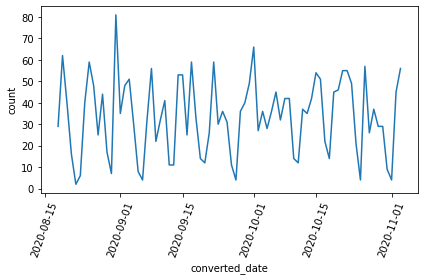

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,name,Page or Account URL,List,State,state,Facebook Id,Group Name,User Name,Likes at Posting,Created,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
884,Mexicanos en st Louis Missouri,https://www.facebook.com/groups/266476490213644,Latinos+EstadosGroups,Missouri,Missouri,266476490213644,Mexicanos en st Louis Missouri,NaN,10160.0,2020-10-24 12:04:46 EDT,...,Red Latina - La ironía de Trump sobre inmigrac...,10/24/20 ¿Cuál es la posición de los candidato...,NaN,NaN,0,-54.0,Trump’s Immigration Irony Offer Biden an Oppor...,Trump’s Immigration Irony Offer Biden an Oppor...,NaN,2020-10-24


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [17]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Arizona,1
1,Arkansas,2
2,California,108
3,Colorado,3
4,Connecticut,3
5,Florida,1083
6,Georgia,66
7,Illinois,37
8,Indiana,1
9,Iowa,5


In [18]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Arizona,1
1,Arkansas,2
2,California,108
3,Colorado,3
4,Connecticut,3
5,Florida,1083
6,Georgia,66
7,Illinois,37
8,Indiana,1
9,Iowa,5


## 3. Which groups are publishing the majority of the content

In [19]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
TRABAJOS PARA LATINOS - HOUSTON,130
Venezolanos en Miami,126
Venezolanos en La Florida,93
Cubanos en miamifl,86
Ecuatorianos en La Florida,80
...,...
Minnesota Council on Latino Affairs,1
Miami-Dade Cuban-American Dems,1
Mexicanos en washington virginia !!,1


In [20]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (63, 40)
republicans (150, 40)
general politics (2, 40)
none (2461,)


727

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [21]:
posts_democrats['MessageDescr'][3:6]

84     Mañana (martes, 1 de septiembre a la 1:00 p.m....
117     Cards in the Mirror, by Armando de Armas: "Ev...
224    # My midday coffee rant: # “When the personal,...
Name: MessageDescr, dtype: object

In [22]:
posts_democrats.columns

Index(['name', 'Page or Account URL', 'List', 'State', 'state', 'Facebook Id',
       'Group Name', 'User Name', 'Likes at Posting', 'Created', 'Type',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly', 'party',
       'converted_date'],
      dtype='object')

In [23]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [24]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [25]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [26]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [27]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
32,Arizona,0,0,0,1
30,Arkansas,0,0,0,2
6,California,2,8,0,100
28,Colorado,0,0,0,3
27,Connecticut,0,0,0,3
0,Florida,20,46,1,1032
16,Georgia,0,2,0,64
14,Illinois,1,6,0,31
34,Indiana,0,0,0,1
25,Iowa,0,0,0,5


In [28]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

Series([], Name: MessageDescr, dtype: object)

## FB Groups Political Posts

In [29]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,Florida,67
1,Virginia,55
2,Maryland,18
3,Texas,15
4,California,10
5,New York,10
6,New Jersey,8
7,Illinois,7
8,Tennessee,4
9,Ohio,4


## Tokenize words and Clean-up text

In [30]:
content = posts.copy()
content['MessageDescr']

0                                                                                                                                                                                           New Immigration Fees Starting October 2! \n\nNueva Tarifas de Inmigracion a partir del 2 de Octubre. NYC Council District 38 https://www.facebook.com/NYCCouncilMember38/photos/a.1071273779651661/2989789584466728/?type=3
1       El Juez Jeffrey White, de California, cancela el aumento de precios sobre las tarifas de inmigración que iba a entrar en efecto el 2 de Octubre. ¡Buenas noticias!\nEl Juez Jeffrey White, de California, cancela el aumento de precios sobre las tarifas de inmigración que iba a entrar en efecto el 2 de Octubre. \nEstas tarifas tenían un aumento significativo como por ejemplo, la ciudadanía iba a c...
2                              Join us this Thursday for a Know Your Rights presentation regarding Immigration and Domestic Violence. Get your questions answered by a Queens Defenders 

In [31]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(2630,)

In [32]:
# Convert to list
data = content.cleanMessage.tolist()

In [33]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['new', 'immigration', 'fees', 'starting', 'october', 'nueva', 'tarifas', 'de', 'inmigracion', 'partir', 'del', 'de', 'octubre', 'nyc', 'council', 'district'], ['el', 'juez', 'jeffrey', 'white', 'de', 'california', 'cancela', 'el', 'aumento', 'de', 'precios', 'sobre', 'las', 'tarifas', 'de', 'inmigracion', 'que', 'iba', 'entrar', 'en', 'efecto', 'el', 'de', 'octubre', 'buenas', 'noticias', 'el', 'juez', 'jeffrey', 'white', 'de', 'california', 'cancela', 'el', 'aumento', 'de', 'precios', 'sobre', 'las', 'tarifas', 'de', 'inmigracion', 'que', 'iba', 'entrar', 'en', 'efecto', 'el', 'de', 'octubre', 'estas', 'tarifas', 'tenian', 'un', 'aumento', 'significativo', 'como', 'por', 'ejemplo', 'la', 'ciudadania', 'iba', 'costar', 'cuando', 'actualmente', 'cuesta', 'uno', 'de', 'los', 'argumentos', 'usados', 'para', 'lograr', 'esta', 'victoria', 'fue', 'que', 'chad', 'wolf', 'no', 'tenia', 'la', 'autorizacion', 'para', 'tomar', 'esta', 'decision', 'sobre', 'los', 'precios', 'uscis', 'inmigracion

#### Creating Bigram and Trigram Models

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['new', 'immigration', 'fees', 'starting', 'october', 'nueva', 'tarifas', 'de', 'inmigracion', 'partir', 'del', 'de', 'octubre', 'nyc', 'council', 'district']


## Remove Stopwords, Make Bigrams and Lemmatize

In [36]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [37]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [39]:
print(data_words_nostops[1:2])

[['juez', 'jeffrey', 'white', 'california', 'cancela', 'aumento', 'precios', 'tarifas', 'inmigracion', 'iba', 'entrar', 'efecto', 'octubre', 'buenas', 'noticias', 'juez', 'jeffrey', 'white', 'california', 'cancela', 'aumento', 'precios', 'tarifas', 'inmigracion', 'iba', 'entrar', 'efecto', 'octubre', 'tarifas', 'tenian', 'aumento', 'significativo', 'ejemplo', 'ciudadania', 'iba', 'costar', 'actualmente', 'cuesta', 'argumentos', 'usados', 'lograr', 'victoria', 'chad', 'wolf', 'tenia', 'autorizacion', 'tomar', 'decision', 'precios', 'uscis', 'inmigracion', 'immigration', 'immigrantes', 'estadosunidos', 'usa', 'nova', 'law', 'firm']]


## Bag of Words

In [40]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [41]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [42]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [43]:
final_dict.most_common(1000)

[('legal', 1081),
 ('asilar', 510),
 ('abogar', 445),
 ('procesar', 442),
 ('residenciar', 419),
 ('casar', 401),
 ('inmigracion', 388),
 ('ano', 384),
 ('inmigrante', 336),
 ('trabajar', 330),
 ('estatus', 320),
 ('ley', 314),
 ('consultar', 311),
 ('formulario', 307),
 ('permanente', 303),
 ('tramitar', 299),
 ('migratorio', 295),
 ('dar', 292),
 ('hoy', 277),
 ('trump', 262),
 ('services', 253),
 ('comenzar', 251),
 ('unir', 245),
 ('personar', 243),
 ('familia', 240),
 ('poder', 238),
 ('tramite_migratorio', 220),
 ('podemos_ayudarlo', 214),
 ('hacer', 211),
 ('permiso', 210),
 ('ayudar', 206),
 ('asilopolitico', 205),
 ('preparador', 203),
 ('ofrecemos_asesoria', 201),
 ('abogados_americanos', 200),
 ('hacemos_promesas', 200),
 ('garantias', 200),
 ('discrecional', 200),
 ('preguntar', 191),
 ('decir', 189),
 ('informacion_general', 186),
 ('constituye_consejo', 186),
 ('revisar', 179),
 ('daca', 173),
 ('visar', 171),
 ('programar', 163),
 ('familiar', 163),
 ('presentar', 160),


In [44]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [45]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

      aaron  abajar  abandonar  abarcar  aberrante  abertos  abide  able  \
0         0       0          0        0          0        0      0     0   
1         0       0          0        0          0        0      0     0   
2         0       0          0        0          0        0      0     0   
3         0       0          0        0          0        0      0     0   
4         0       0          0        0          0        0      0     0   
...     ...     ...        ...      ...        ...      ...    ...   ...   
2625      0       0          0        0          0        0      0     0   
2626      0       0          0        0          0        0      0     0   
2627      0       0          0        0          0        0      0     0   
2628      0       0          0        0          0        0      0     0   
2629      0       0          0        0          0        0      0     0   

      abogadafiera  abogadalatina  ...  www  www_jaimebarron  yadira  year  \
0        

In [46]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [47]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
legal,2.384396
asilar,2.888667
procesar,2.903857
inmigracion,3.028681
casar,3.178026
...,...
idontgiveup,8.181972
ignorar,8.181972
igualmente,8.181972
entizar,8.181972


In [48]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [49]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [50]:
df

,tfidf
council,0.510380
district,0.485087
inmigracion,0.188925
nuevo,0.291334
nyc,0.485087
octubre,0.263310
tarifar,0.281057


In [51]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,"there is a better way, the wright way! #sosaforcongress #votegold #endincometax #endfederalspending #fiximmigration #freetheweed sosa for us representative district 9",4
1,"register here today: 👇🏼www.palatinoconvention.com\n\nconvention schedule\nthursday, october 29 \nprofessional development \n\n10:00 am - 1:00 pm\n\nworkshop #1 – latino health and covid19 – dr. oralia dominic, highmark \n\nworkshop #2 – latinas in the media panel: latina publishers leading the message – jennie jenkins-dallas, la voz latina central newspaper, harrisburg, pa; rosa julia parra, ...",2
2,"we are on live!\n📍join our facebook live video now! \nwe will present to you:\n🇺🇲 immigration and tax law update with the immigration attorney tawsif chowdhury from chowdhury immigration law firm.\n🏘 islamic home, commercial & masjid financing with the district manager obayed rahaman from uif.\nyou will be able to call us during this live video to answer your questions at 972-330-3800. chowdh...",2
3,"vota por el cambio verdadero! vota por lo correcto! #votegold #sosaforcongress there is a better way, the wright way! #sosaforcongress #votegold #endincometax #endfederalspending #fiximmigration #freetheweed sosa for us representative district 9",1
4,"vota por el cambio verdadero! vota por lo correcto! #votegold #sosaforcongress #fiximmigration there is a better way, the wright way! #sosaforcongress #votegold #endincometax #endfederalspending #fiximmigration #freetheweed sosa for us representative district 9",1
5,"ice trasladó a los detenidos a virginia para que los aviones pudieran transportar agentes a las protestas de d.c. siguió un gran brote de coronavirus. the trump administration flew immigrant detainees to virginia this summer to facilitate the rapid deployment of homeland security tactical teams to quell protests in washington, circumventing restrictions on the use of charter flights for employ...",1
6,"but there are policy changes that biden could undertake unilaterally and immediately upon assuming office: he could reverse some of trump’s signature immigration policies, including the travel ban and his pandemic-related restrictions on legal immigration, and begin the immense task of reforming the immigration agencies by installing new leadership and revising their enforcement priorities. he...",1
7,hoy nos remontaremos en la historia reciente y sacaremos conclusiones importantes sobre quienes son los verdaderos culpables para que hasta el dia de hoy no hayamos tenido una reforma migratoria. los republicanos no quieren desde el 2001 hacer ninguna reforma migratoria. lo que quieren ellos es que se cumplan las leyes por mas resultados inhumanos que estos produzcan. while speaking in his ho...,1
8,new immigration fees starting october 2! \n\nnueva tarifas de inmigracion a partir del 2 de octubre. nyc council district 38,1
9,"officers with the u. s. immigration and customs enforcement announced the arrests of 42 people, including 27 convicted criminals in the district and commonwealth. three of the people arrested also have pending charges. the aliens targeted during this operation preyed on men, women and children in ou... ice arrests 42 in latest operation in d.c. and virginia",1


### Repeated messages

In [52]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [53]:
results.sort_values(by='Counts',ascending=False)

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
Este es el mejor momento para acercarte a Laura y pedirle una consulta para revisar tu estatus en el proceso de tu inmigración a los Estados Unidos. El despacho de Laura tiene experiencia y sabe los mejores caminos para alcanzar los objetivos de sus clientes bajo la ley. La primera consulta es gratis! #AskLauraJ Teléfono: (786) 319 7074 Email: info@ljimenezpa.com Website: https://ljimenezpa.com #laurajimenezpa #immigration #inmigracion #immigrationlaw #citizenship #ciudadania #greencard #immigrationattorney #businessvisa #asilo #visa #visainversionista #consulado #visaestudiante #deportacion #studentvisa #visadeestudiante #visahabilidadextrarodinaria #visa0_1 https://www.facebook.com/ImmigrationLawFL/photos/a.134307491288697/345325650186879/?type=3,https://www.facebook.com/ImmigrationLawFL/photos/a.134307491288697/345325650186879/?type=3,32,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
Acércate a Laura para revisar tu proceso de inmigración a los Estados Unidos. El despacho de Laura tiene experiencia y sabe los mejores caminos para alcanzar los objetivos de sus clientes bajo la ley. ¡La primera consulta es GRATIS! #AskLauraJ Teléfono: (786) 319 7074 Email: info@ljimenezpa.com Website: https://ljimenezpa.com #laurajimenezpa #immigration #inmigracion #immigrationlaw #citizenship #ciudadania #greencard #residencia #immigrationattorney #businessvisa #asilo #visa #visainversionista #consulado #visaestudiante #deportacion #studentvisa #visadeestudiante #visahabilidadextrarodinaria #visa01 #daca #dreamers https://www.facebook.com/ImmigrationLawFL/photos/a.134307491288697/360544365331674/?type=3,https://www.facebook.com/ImmigrationLawFL/photos/a.134307491288697/360544365331674/?type=3,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
"Necesitas hacer una petición familiar? Nosotros te podemos ayudar con ese proceso o con cualquier otro tramite Residencia, Remoción de Residencia, Renovación de Residencia, Ciudadania, Ajuste de Estatus, Renovar Permiso de Trabajo, Permiso de Viaje, Affidavit Support, Extension de Visa, Proceso Consular, te ofrecemos también servicios de notarizacion, para cualquier pregunta llámanos o manda un text por WhatsApp al 786-282-1854, será un gusto ayudarte. Immigration Legal Solutions https://www.facebook.com/708463026219143/photos/a.715728808825898/1220444141687693/?type=3",https://www.facebook.com/708463026219143/photos/a.715728808825898/1220444141687693/?type=3,21,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
"⚖⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⚖ ¡LLAMENOS HOY PARA PROGRAMAR UNA CONSULTA Y ARREGLAR SU ESTATUS MIGRATORIO! *Consulta de teléfono preliminaria gratis* ABOGADAS DE INMIGRACIÓN *Se Habla Español* PAOLA VIBRIESCA 301-531-4161 pavibriesca@nvimmigrationlaw.com DEBORAH NINAN 301-531-4163 deborah.s.ninan@nvimmigrationlaw.com Llamenos al 301-531-4161 | 301-531-4163 PODEMOS AYUDAR CON: •Conseguir Fianza Para Familiares Detenidos •Peticiónes de Familia •Representación en su Caso de Deportación •El Asilo •La Visa U •Aplicaciónes Para la Ciudadanía •Aplicaciónes Para la Residencia Permanente •¡Y Mucho Más! OFFICE ADDRESS: 6411 Ivy Lane, Suite 305, Greenbelt, MD 20770 INSTAGRAM: https://www.instagram.com/tv/CBoNptoFzax/?utm_source=ig_web_copy_link FACEBOOK: https://www.facebook.com/Las-Dos-Amigas-En-La-Ley-104072181481526/ WEBSITE: http://www.nvimmigrationlaw.com Detailed, Dedicated, Driven NV Immigration Law http://www.nvimmigrationlaw.com/",http://www.nvimmigrationlaw.com/,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
"Haz tus trámites de Inmigración con Immigration Legal Solutions!!Aplicación de Residencia, Renovacion de Residencia, Ciudadania, Ajuste de Estatus, Renovación Permiso de Trabajo, Peticion Visa Fiance, DACA, Perdon Migratorio, Petición Familiar, Permiso de Viaje, Extensión de Visa de Turista, Proceso Consular, también tenemos servicios de Notario Publico, Traducciones, llamanos o manda un text por WhatsApp al 776-282-1854, será un gust

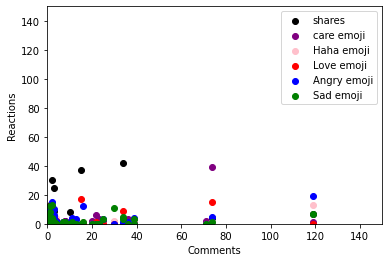

In [54]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [55]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


[[('council', 1),
  ('district', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('octubre', 1),
  ('tarifar', 1)]]

## Buiding the Topic Model

In [56]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [57]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"nj" + 0.000*"gobernador" + 0.000*"ocupacional" + 0.000*"governor" + '
  '0.000*"stronger" + 0.000*"lawyers" + 0.000*"diasporalaw" + '
  '0.000*"immigrationlaw" + 0.000*"presenciar" + 0.000*"usarse"'),
 (1,
  '0.174*"daca" + 0.073*"tambien" + 0.072*"permiso" + 0.054*"servicio" + '
  '0.046*"familiar" + 0.037*"hijo" + 0.035*"solutions" + 0.032*"preguntar" + '
  '0.031*"llegar" + 0.031*"programar"'),
 (2,
  '0.234*"preguntar" + 0.057*"affairs" + 0.053*"country" + 0.029*"poder" + '
  '0.022*"capacidad" + 0.015*"adelantar" + 0.013*"suenos" + '
  '0.007*"realidad_sigue" + 0.007*"convertir" + 0.000*"viernes"'),
 (3,
  '0.287*"legal" + 0.107*"ano" + 0.098*"asilar" + 0.056*"tramitar" + '
  '0.056*"dar" + 0.055*"inmigracion" + 0.033*"ciudadano" + 0.025*"tambien" + '
  '0.024*"familiar" + 0.022*"solicitud"'),
 (4,
  '0.187*"abogar" + 0.105*"consultar" + 0.085*"ayudar" + 0.076*"hoy" + '
  '0.075*"immigration" + 0.045*"casar" + 0.043*"temer" + 0.038*"office" + '
  '0.038*"programar" 

## Compute Model Perplexity and Coherence Score

In [58]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.55747265132794

Coherence Score:  0.39848286834547897


## Visualize the topics-keywords

In [59]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.209735 -0.305181       1        1  15.820082
9      0.235409  0.186163       2        1  11.627455
10     0.181488  0.153411       3        1  10.510549
6      0.114983 -0.108607       4        1   9.268316
4      0.133231  0.011781       5        1   6.832932
18     0.107989  0.150675       6        1   5.615334
7     -0.057859 -0.053677       7        1   5.423369
5      0.002210 -0.147744       8        1   5.293381
11    -0.031284  0.015693       9        1   4.487188
1      0.065066 -0.040508      10        1   4.374872
13    -0.020209 -0.021798      11        1   4.318351
17    -0.055579 -0.028648      12        1   4.122447
16    -0.059796  0.075103      13        1   3.247009
15    -0.032726  0.059965      14        1   2.597002
8     -0.081383 -0.008959      15        1   2.158087
19    -0.123960 -0.039858      16        1   1.963059
12    -0.117838  0.058880      17        1   1.201304
2     -0.148578 -0.002357      18        1   0.705682
14    -0.160788  0.022113      19        1   0.352000
0     -0.160111  0.023553      20        1   0.081584, topic_info=                 Term         Freq        Total Category  logprob  loglift
39              legal  2376.000000  2376.000000  Default  30.0000  30.0000
152             trump   957.000000   957.000000  Default  29.0000  29.0000
178        inmigrante   537.000000   537.000000  Default  28.0000  28.0000
432            abogar   709.000000   709.000000  Default  27.0000  27.0000
220               ano   902.000000   902.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1132           amplio     0.008773     1.482397  Topic20  -8.4909   1.9815
1481             info     0.008773     1.482292  Topic20  -8.4909   1.9816
3835  aproximadamente     0.008773     1.482509  Topic20  -8.4909   1.9815
998            futuro     0.008773     1.482580  Topic20  -8.4909   1.9814
833             decir     0.008773     1.485975  Topic20  -8.4909   1.9791

[785 rows x 6 columns], token_table=      Topic      Freq                         Term
term                                              
689       4  0.654970                            1
689       5  0.316193                            1
512       5  0.934799  abogadalatina_abogadolatino
432       5  0.945079                       abogar
432       7  0.030986                       abogar
...     ...       ...                          ...
87        7  0.900315                      visitar
625       8  0.996289                        vivir
218      12  0.964293                       volver
644       3  0.884788                     whatsapp
670       9  0.977471                           ﻿1

[602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 11, 7, 5, 19, 8, 6, 12, 2, 14, 18, 17, 16, 9, 20, 13, 3, 15, 1])

## Building LDA Mallet Model

In [60]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [70]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [73]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [74]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [75]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('presentar', 0.06508391322144903),
   ('poder', 0.06017191977077364),
   ('llamanos', 0.05116659844453541),
   ('casar', 0.04338927548096602),
   ('solicitud', 0.029062627916496112),
   ('hijo', 0.02660663119115841),
   ('personar', 0.018419975440032748),
   ('abusar', 0.015554645927138764),
   ('necesidad', 0.015554645927138764),
   ('dejar', 0.015554645927138764)]),
 (4,
  [('decir', 0.0418712099335836),
   ('trump', 0.021368755414380596),
   ('ninos', 0.017326017903551833),
   ('federal', 0.01674848397343344),
   ('presidente', 0.014438348252959862),
   ('pasar', 0.013860814322841466),
   ('ano', 0.01357204735778227),
   ('inmigrante', 0.012994513427663876),
   ('cortar', 0.01241697949754548),
   ('coronavirus', 0.01155067860236789)]),
 (1,
  [('dudar', 0.0505097312326228),
   ('casar', 0.04448563484708063),
   ('oportunidad', 0.04402224281742354),
   ('saber', 0.033364226135310475),
   ('enviar', 0.032900834105653386),
   ('consultar', 0.030120481927710843),
   ('ayudarte

## Finding the optimal number of topics for LDA

In [76]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [77]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

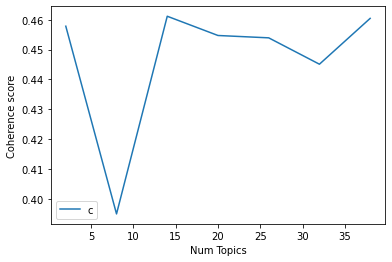

In [78]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4578
Num Topics = 8  has Coherence Value of 0.395
Num Topics = 14  has Coherence Value of 0.4612
Num Topics = 20  has Coherence Value of 0.4547
Num Topics = 26  has Coherence Value of 0.4539
Num Topics = 32  has Coherence Value of 0.4451
Num Topics = 38  has Coherence Value of 0.4604


In [80]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.065*"familia" + 0.044*"querer" + 0.040*"mensaje" + 0.032*"siempre" + '
  '0.029*"importante" + 0.027*"redes_sociales" + 0.027*"siguenos" + '
  '0.027*"privado_contactenos" + 0.027*"informacion_enviamos" + 0.025*"saber"'),
 (1,
  '0.085*"asilar" + 0.031*"miedo_creible" + 0.024*"tiempo" + 0.022*"negar" + '
  '0.020*"oficial" + 0.018*"solicitar" + 0.017*"juez" + 0.016*"order" + '
  '0.016*"caso" + 0.015*"necesitar"'),
 (2,
  '0.057*"legal" + 0.049*"formulario" + 0.045*"tramitar" + 0.042*"comenzar" + '
  '0.039*"dar" + 0.038*"services" + 0.037*"tramite_migratorio" + '
  '0.036*"podemos_ayudarlo" + 0.035*"asilar" + 0.034*"asilopolitico"'),
 (3,
  '0.067*"consultar" + 0.047*"abogar" + 0.043*"legal" + 0.040*"llamenos" + '
  '0.038*"hoy" + 0.038*"programar" + 0.027*"arreglar" + 0.023*"aplicación" + '
  '0.020*"ayudar" + 0.019*"meneses"'),
 (4,
  '0.046*"trump" + 0.019*"federal" + 0.017*"ahora" + 0.015*"decir" + '
  '0.014*"mexico" + 0.012*"votar" + 0.011*"coronavirus" + 0.011*"ir" + 

## Finding the dominant topic in each sentence

In [81]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.0919,"casar, migratorio, inmigracion, pasar, informar, dar, contar, iniciar, canada, tomar",New Immigration Fees Starting October 2! Nueva Tarifas de Inmigracion a partir del 2 de Octubre. NYC Council District 38
1,1,10.0,0.1936,"permiso, legal, daca, trabajar, hoy, ayudar, tarifar, familiar, servicio, solutions","El Juez Jeffrey White, de California, cancela el aumento de precios sobre las tarifas de inmigración que iba a entrar en efecto el 2 de Octubre. ¡Buenas noticias! El Juez Jeffrey White, de California, cancela el aumento de precios sobre las tarifas de inmigración que iba a entrar en efecto el 2 de Octubre. Estas tarifas tenían un aumento significativo como por ejemplo, la ciudadanía iba a cost..."
2,2,8.0,0.0831,"residenciar, legal, permanente, estatus, unir, trabajar, personar, elegible, tarjeta, migratorio","Join us this Thursday for a Know Your Rights presentation regarding Immigration and Domestic Violence. Get your questions answered by a Queens Defenders Social Worker and Immigration Advocate. To RSVP, email bvasquez@queensdefenders.org and svaca@queensdefenders.org. Queens Defenders"
3,3,9.0,0.2131,"decir, trump, ano, ninos, estadounidense, presidente, manera, separar, encontrar, publicar","👉 Quedan cordialmente invitados a la Conferencia sobre Lotería de Visas DV 2022!!! ¡DESDE LA COMODIDAD DE TU CASA O DE TU TRABAJO! 👏👏 💁‍♀️ Recibe información totalmente GRATIS, y sobre todo real y de primera mano respecto al gran programa de visas de diversidad DV2022 o Green Card, y así podrías cumplir el Sueño de ir a Vivir, trabajar y/o estudiar de manera legal en los Estados Unidos de Nor..."
4,4,1.0,0.4019,"asilar, miedo_creible, tiempo, negar, oficial, solicitar, juez, order, caso, necesitar","🇺🇸 ✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸 Durante este tiempo loco de pandemia, nuestra oficina presentó muchas extensiones de estadía turística. ¿Cuándo se recomienda solicitar una extensión? -sus vuelos para regresar a su país han sido cancelados o no están disponibles y la fecha límite se acerca; -Está en el grupo de riesgo o tiene una salud frágil y no puede viajar durante una pandemia; -Necesi..."
5,5,1.0,0.3970,"asilar, miedo_creible, tiempo, negar, oficial, solicitar, juez, order, caso, necesitar","🇺🇸 ✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸✈️🇺🇸 Durante este tiempo loco de pandemia, nuestra oficina presentó muchas extensiones de estadía turística. ¿Cuándo se recomienda solicitar una extensión? -sus vuelos para regresar a su país han sido cancelados o no están disponibles y la fecha límite se acerca; -Está en el grupo de riesgo o tiene una salud frágil y no puede viajar durante una pandemia; -Necesi..."
6,6,9.0,0.1834,"decir, trump, ano, ninos, estadounidense, presidente, manera, separar, encontrar, publicar","Bueno gente hablemos de algo que nos afecta a todos, hace unos dias una enfermera dio la noticia que estaban haciendo hysterectomias a mujeres en los campos de concentracion de ICE, les sacan todo el utero y ellas nisiquiera saben o entienden porque. y esto es lo poco que sabemos se a especulado que venden a los niños y los trafican, violan, matan, y venden a nuestra gente. Ya no podemos queda..."
7,7,0.0,0.2684,"familia, querer, mensaje, siempre, importante, redes_sociales, siguenos, privado_contactenos, informacion_enviamos, saber","Desafortunadamente, ahora tenemos algunos clientes detenidos por ICE. Estamos a punto de ir a una audiencia de fianza ante el juez de inmigración y el fiscal del DHS. El trabajo del DHS siempre es impugnar la fianza, depende completamente del juez en este momento si nuestro cliente será deportado o liberado. Incluso si se otorga la fianza, será de al menos 10k a 20k. Siempre fiel para alcanza..."
8,8,4.0,0.0925,"trump, federal, ahora, decir, mexico, votar, coronavirus, ir, centrar, cortar","BIDEN JOINS HISPANIC HERITAGE MONTH EVENT IN FLORIDA: Joe Biden hosts a Hispanic Heritage Month event in Kissimmee, Florida. Earlier today, Biden 

## Find the most representative document for each topic

In [85]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4109,"familia, querer, mensaje, siempre, importante, redes_sociales, siguenos, privado_contactenos, informacion_enviamos, saber","¿Quieres emigrar junto a tu familia? Queremos que junto a tu familia sean parte del sueño americano Nosotros podemos asistirte Para más información enviamos un mensaje al privado o contáctenos, síguenos en nuestras redes sociales y con gusto te atenderemos: Facebook: Family First Immigration Instagram: @ffimmigration Para nosotros la #familia es lo primero #inmigration #familyfirst #family #us..."
1,1.0,0.4746,"asilar, miedo_creible, tiempo, negar, oficial, solicitar, juez, order, caso, necesitar",Do you know Alexander Hamilton? Would you like to know some of his best phrases? Well here in The Alternative we will bring you your own words and our opinions. Read them carefully... ′′ It is an undisputed truth that the whole people of each country sincerely desire their prosperity; but it is equally irrefutable that it does not possess the discernment and stability necessary for a systemat...
2,2.0,0.4482,"legal, formulario, tramitar, comenzar, dar, services, tramite_migratorio, podemos_ayudarlo, asilar, asilopolitico",Eres elegible para la naturalización si: * Has sido Residente Permanente durante al menos 5 años y reunes todos los requisitos de elegibilidad. * Has sido Residente Permanente por 3 años o más y reunes todos los requisitos para tramitar la naturalización como cónyuge de un ciudadano americano. * Estás en el servicio activo en la Fuerzas Armadas de los EEUU y reunes los demás requisito...
3,3.0,0.5200,"consultar, abogar, legal, llamenos, hoy, programar, arreglar, aplicación, ayudar, meneses","Várias pessoas estão tendo respostas favoráveis nas etapas para finalizar o processo do Status e ter o SIJS aprovado através do excelente trabalho do nosso advogado de imigração! Nesse Post temos mais um jovem: Jean Louis (um dos filhos da Catherine Purpura, CEO da CNN Legal Services). . Mas você sabe o que é SIJS? Special Immigrant Juveline Status (SIJS) é a possibilidade de legalização ..."
4,4.0,0.6230,"trump, federal, ahora, decir, mexico, votar, coronavirus, ir, centrar, cortar","Otros artistas latinos también convidan a sus seguidores para que voten por el candidato demócrata. Marc Anthony convidó a sus más de 10 millones de seguidores en Instagram a votar por el candidato demócrata Joe Biden en las venideras elecciones presidenciales del 3 noviembre, comicios donde el ex vicepresidente de Estados Unidos pretende derrotar a Donald Trump. El domingo, la imagen del sals..."
5,5.0,0.4566,"casar, migratorio, inmigracion, pasar, informar, dar, contar, iniciar, canada, tomar","DHS Proposes Rule to Strengthen Affidavit of Support Process: ""The proposed update would require American citizens, U.S. nationals and lawful permanent residents who choose to sponsor an immigrant by submitting a Form I-864, Affidavit of Support Under Section 213A of the INA, or Form I-864EZ, Affidavit of Support Under Section 213A of the INA, to provide credit reports and credit scores, cert..."
6,6.0,0.5373,"inmigrante, ano, obtener, ciudadano, prometer, tambien, ee_uu, extranjero, empresa, mayor","¿Cómo obtener una Green Card? La residencia permanente o Green Card es el estatus migratorio para vivir y trabajar legal y permanentemente en EU. En la mayoría de los casos se requiere de un patrocinador, ya sea un familiar o un empleador, aunque también se puede obtener independientemente, mediante una sustancial inversión monetaria o un golpe de suerte en la Lotería de Visas del Departamento..."
7,7.0,0.5483,"casar, presentar, abogar, poder, ley, inmigrante, perder, hijo, victimar, personar","La visa de No Inmigrante O-1 es para personas que poseen habilidades extraordinarias en las ciencias, artes, educación, negocios o atletismo, o han demostrado un récord de logros extraordinarios en la industria de películas o industria televisiva y han sido reconocidos nacional 

In [86]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [87]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"casar, migratorio, inmigracion, pasar, informar, dar, contar, iniciar, canada, tomar",305.0,0.1160
1.0,10.0,"permiso, legal, daca, trabajar, hoy, ayudar, tarifar, familiar, servicio, solutions",176.0,0.0669
2.0,8.0,"residenciar, legal, permanente, estatus, unir, trabajar, personar, elegible, tarjeta, migratorio",157.0,0.0597
3.0,9.0,"decir, trump, ano, ninos, estadounidense, presidente, manera, separar, encontrar, publicar",238.0,0.0905
4.0,1.0,"asilar, miedo_creible, tiempo, negar, oficial, solicitar, juez, order, caso, necesitar",173.0,0.0658
5.0,1.0,"asilar, miedo_creible, tiempo, negar, oficial, solicitar, juez, order, caso, necesitar",153.0,0.0582
6.0,9.0,"decir, trump, ano, ninos, estadounidense, presidente, manera, separar, encontrar, publicar",113.0,0.0430
7.0,0.0,"familia, querer, mensaje, siempre, importante, redes_sociales, siguenos, privado_contactenos, informacion_enviamos, saber",129.0,0.0490
8.0,4.0,"trump, federal, ahora, decir, mexico, votar, coronavirus, ir, centrar, cortar",68.0,0.0259
9.0,9.0,"decir, trump, ano, ninos, estadounidense, presidente, manera, separar, encontrar, publicar",104.0,0.0395
